# Welcome to PACKAGE_NAME!

## Introduction

PACKAGE_NAME is a python software package that helps you apply and evaluate a range of different bias correction methods to your climate model data. **This notebook guides you through the workflow of bias correcting the variable 'tas' (2m surface temperature) using PACKAGE_NAME. The notebook is ideal if you are new to bias correction and want to familiarize yourself with the different steps without yet going into the details of each of them.**

**Requirements for starting this notebook**

- Downloaded and pre-processed testing data. You can either use your own data, use the testing data prepared and stored in FOLDER or download your own testing data.
- PACKAGE REQUIREMENTS?


**Link to other notebooks and documentation pages**
- If you want to download and pre-process observational and climate model testing data first, start with this notebook.
- For an introduction to the idea and general methodology of bias correction, have a look at this page LINK.
- LINK gives a more advanced overview of how to initialize apply different debiasers and the choices the user can make.
- For a detailed overview of evaluation methods available, have a look at the evaluation notebook LINK.

## Load required packages

In [8]:
import sys
sys.path.append("../")  # path contains python_file.py

In [9]:
import numpy as np
import iris
from scipy.stats import norm

The variable class provides a standard definition template for meteorological variables that can be bias corrected. A standard set of variables specified in DOCUMENTATION is initalized out of the box.

In [ ]:
from PACKAGE_NAME.variables import *

The classes LinearScaling and ISIMIP are child classes of the more general Debiaser class and contain the core calculations necessary for each bias correction method.

In [ ]:
from PACKAGE_NAME.debias import LinearScaling, ISIMIP

The evaluate module provides a set of functions useful for evaluating the performance of the bias correction method. The functions are grouped by functionality - marginal, for example, contains all functions to conduct a marginal, that is location-wise evaluation.

In [ ]:
from PACKAGE_NAME.evaluate import marginal
from PACKAGE_NAME.evaluate.metrics import *

## Loading testing data

This step requires you to have downloaded and preprocessed observational or reanalysis data (such as ERA5) as well as a historical, as well as a future simulation of a climate model. Necessary pre-processing steps include:
- Regridding the datasets to the same area and grid in space and time
- Conducted checks for corrupted or missing data

If you don't have testing data yet, you can either work with the testing data stored in FOLDER, or use the PREPROCESS_NOTEBOOK to download new testing data.

In order to evaluate the performance of different bias correction methods before choosing the one to use for the future application period, we split the historical data for which we have observations into a training and a validation period. The parameter 'split_ratio' in the function 'preprocess_isimip_evaluation_testing_data' defines the ratio of training data points vs validation data points.

**OPEN QUESTION** - which file to put these functions in?

In [25]:
from cf_units import num2date

def get_dates(x):
    
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable, split_ratio):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    if obs_all.shape != cm.shape:
        raise ValueError('Observation and climate model data do not have same dimensions.')
    
    boundary_step = math.floor(obs_all.shape[2]*split_ratio)
    
    obs = obs_all[:, :, 0:boundary_step]
    obs_validate = obs_all[:, :, boundary_step+1:]
    cm_hist = cm[:, :, 0:boundary_step]
    cm_validate = cm[:, :, boundary_step+1:]
    
    cm_future = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_validate),
    }
    
    dates_future = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_validate = np.transpose(np.array(cm_validate.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_validate, cm_future, dates, dates_future

In [26]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_validate, tas_cm_future, tas_dates_validate, tas_dates_future = preprocess_isimip_evaluation_testing_data(variable = 'tas', split_ratio = 0.7)

## Initializing the debiaser

We are going to initialize two debiasers that we can later apply to our testing data: 
- Linear Scaling, a simple bias correction method that corrects the mean and variance of the climate model, keeping their ratio constant.
- ISIMIP, a trend-preserving parametric quantile mapping method, explained in detail in the class documentation LINK.

Even though the two debiasers have very different degrees of complexity, the can both be initialized in a similarly simple manner by specifying the variable you wish to debias. This initializes a set of default settings in both debiasers. These default settings can be manually overwritten, as described in detail in the DEBIASER NOTEBOOK LINK.

**Linear Scaling**

In [33]:
tas_debiaser_LS = LinearScaling.from_variable(variable = 'tas')

**ISIMIP**

In [34]:
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')

## Applying the debiaser on the validation period

We now apply these initialized debiasers to the testing data in our validation period defined above.

**Linear Scaling**

In [37]:
tas_val_debiased_LS = tas_debiaser_LS.apply(tas_obs, tas_cm_hist, tas_cm_validate)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|█████████████████████████████████████████| 4/4 [00:00<00:00, 3517.24it/s]


**ISIMIP**

In [38]:
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|███████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]


## Evaluating the bias corrected climate model on the validation period

We have so far only applied the debiaser to the validation period, so that we can compare the performance of different bias correction methods before applying them to the future period. The advantage is that during the evaluation period, our debiased climate model can be compare to observational / reanalysis data and we can therefore assess whether method has actually improved the bias of the climate model compared to observations.

The ThresholdMetrics class provides the functionality to define targeted metrics associated with each variable. In this tutorial, we will simply investigate the occurrence of 'mean warm days' and 'mean cold days'.

In [41]:
tas_metrics = [warm_days, cold_days]

The following function provides an entry point into evaluating the performance of the bias correction method. It calculates the bias of the mean, 5th percentile and 95th percentile of the climate model with respect to observations by default, as well as the bias of the additional metrics specified above.

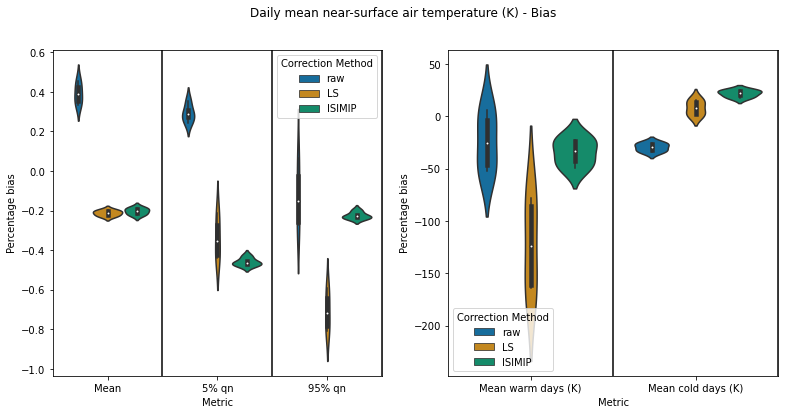

In [40]:
tas_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tas_metrics,obs_data = tas_obs_validate,
                                                          raw = tas_cm_validate, LS = tas_val_debiased_LS,
                                                          ISIMIP = tas_val_debiased_ISIMIP)

marginal.plot_marginal_bias(variable = 'tas', bias_array = tas_marginal_bias_data)

## Apply the debiaser to the future period

In [36]:
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|███████████████████████████████████████████| 4/4 [00:12<00:00,  3.19s/it]


The variable tas_fut_debiased_ISIMIP now contains the bias corrected climate model data for the period 2065-2100. Congratulations!